In [1]:
import numpy as np
import pandas as pd
import datetime
import yfinance as yf
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# For importing universal scripts
import sys
import os
# Go up two levels from the subfolder
sys.path.append(os.path.abspath("../.."))
from indicators_returns import final_df #Universal script for indicator set and actuals

In [2]:
ticker = 'QQQ'
returns = [5, 10, 20, 30, 45, 60, 90]
lb = 20
df = final_df(ticker, returns, lb)
df = df.iloc[:-101].replace([np.inf, -np.inf], 0)

In [9]:
# Identify all indicator columns (same logic as before)
indicator_cols = [col for col in df.columns 
                if col not in ['Date', 'Close', 'High', 'Low', 'Volume']
                and not col.startswith('Return')
                and 'slope' not in col.lower()
]

# Create correlation matrix
indicator_df = df[indicator_cols].dropna()
corr_matrix = indicator_df.corr(method='pearson')

# Unstack upper triangle (excluding self-correlations)
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Melt and filter for high correlations
high_corr_pairs = (
    upper_tri.stack()
    .reset_index()
    .rename(columns={'level_0': 'indicator_1', 'level_1': 'indicator_2', 0: 'correlation'})
)

# Flag pairs with correlation > 0.90
high_corr_pairs = high_corr_pairs[high_corr_pairs['correlation'].abs() > 0.90]
high_corr_pairs.to_csv('highly_correlated_pairs.csv', index=False)


In [ ]:
# Identify all indicator columns (same logic as before)
indicator_cols = [col for col in df.columns 
                if col not in ['Date', 'Close', 'High', 'Low', 'Volume']
                and not col.startswith('Return')
                and 'slope' not in col.lower()
]

# Create correlation matrix
indicator_df = df[indicator_cols].dropna()
corr_matrix = indicator_df.corr(method='pearson')

# Unstack upper triangle (excluding self-correlations)
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Melt and filter for high correlations
low_corr_pairs = (
    upper_tri.stack()
    .reset_index()
    .rename(columns={'level_0': 'indicator_1', 'level_1': 'indicator_2', 0: 'correlation'})
)

# Flag pairs with correlation > 0.90
low_corr_pairs = low_corr_pairs[low_corr_pairs['correlation'].abs() < 0.50]
low_corr_pairs.to_csv('highly_correlated_pairs.csv', index=False)


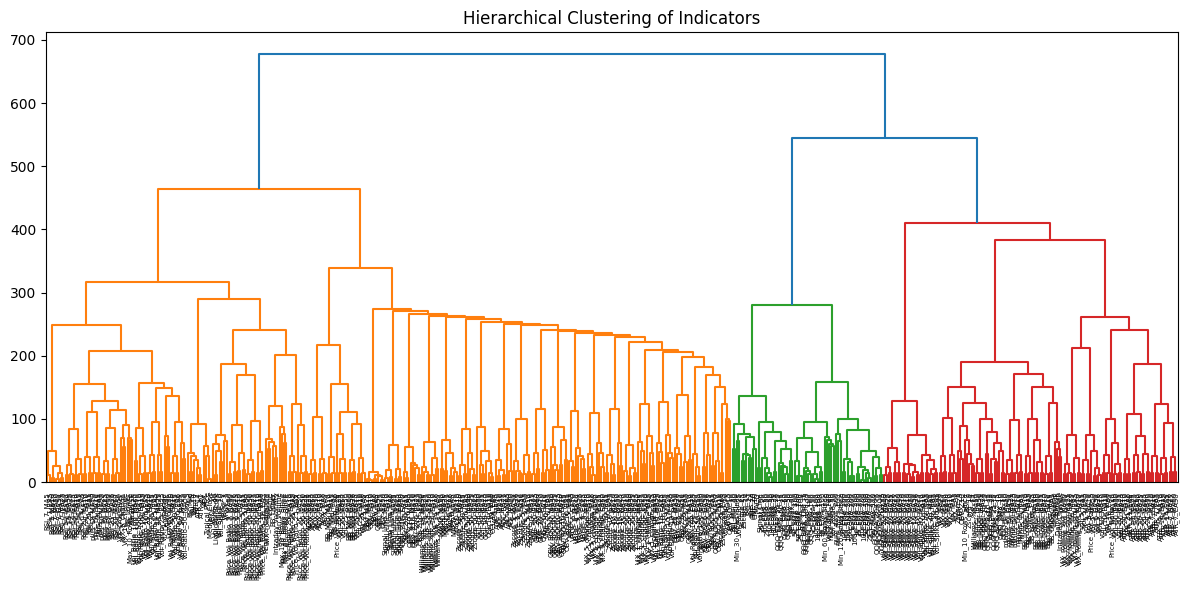

In [10]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns

# Use indicators only
indicator_cols = [col for col in df.columns 
                if col not in ['Date', 'Close', 'High', 'Low', 'Volume']
                and not col.startswith('Return')
                and 'slope' not in col.lower()
]

# Drop rows with any NA in indicators
df_ind = df[indicator_cols].dropna()

# Z-score normalize all indicators
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_ind)

# Compute linkage matrix for hierarchical clustering
link = linkage(X_scaled.T, method='ward')  # transpose to cluster columns (indicators)

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(link, labels=indicator_cols, leaf_rotation=90)
plt.title("Hierarchical Clustering of Indicators")
plt.tight_layout()
plt.show()

In [8]:
from scipy.cluster.hierarchy import fcluster

# Cluster into N groups (e.g., 20), or use a distance threshold (e.g., t=200)
clusters = fcluster(link, t=20, criterion='maxclust')  # or use criterion='distance'

# Create mapping from indicator to cluster
cluster_df = pd.DataFrame({'indicator': indicator_cols, 'cluster': clusters})

cluster_df.to_csv('cluster.csv')